## Projeto 2 - Fundamentos de Sistemas Inteligentes
### Guilherme Rodrigues Lodron Pires - 170011780

- Importando bibliotecas utilizadas no projeto

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

- Separando parte do dataset para treinamento (80%)

In [2]:
dataset = 'Tomato pest image enhancement'
height, width = 299, 299
batch_size = 32
SEED = 123
training = keras.utils.image_dataset_from_directory(
    dataset,
    labels='inferred',
    validation_split=.2,
    image_size=(height, width),
    class_names = None,
    subset='training',
    seed=SEED,
    label_mode='categorical',
    shuffle=True
)

Found 4263 files belonging to 8 classes.
Using 3411 files for training.


 - Separando parte do dataset para validação (20%)

In [3]:
validation = keras.utils.image_dataset_from_directory(
    dataset,
    labels='inferred',
    validation_split=.2,
    image_size=(height, width),
    class_names = None,
    subset='validation',
    seed=SEED,
    shuffle=True,
    label_mode='categorical'
)

Found 4263 files belonging to 8 classes.
Using 852 files for validation.


##### Inspecionando classes possíveis para as imagens
- Cada classe corresponde a um diretório no dataset

In [19]:
class_names = training.class_names
class_names

['BA', 'HA', 'MP', 'SE', 'SL', 'TP', 'TU', 'ZC']

##### Instanciando modelo base para transfer learning
- No caso foi utilizado o ResNet50 com as camadas congeladas

In [5]:
base_model = keras.applications.ResNet50(
    include_top=False,
    input_shape = (height, width, 3),
    pooling='avg',
    classes=8,
    weights='imagenet'
)
for layer in base_model.layers:
    layer.trainable = False

##### Criando modelo a partir do modelo base
- Foi utilizada uma rede neural totalmente conectada com ativação relu
- Para saída uma rede de tamanho 8 com ativação sigmoide para retornar as probabilidades para cada classe

In [6]:
model = keras.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(8, activation='sigmoid')
])
# Inspecionando a estrutura do modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24,640,904
Trainable params: 1,053,192
Non-trainable params: 23,587,712
_________________________________________________________________


##### Compilando modelo utilizando a função de perda para lidar com classes categóricas

In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

##### Treinando modelo em 20 epochs

In [8]:
history = model.fit(training, validation_data=validation, epochs=20)

Epoch 1/20
107/107 [==============================] - 30s 226ms/step - loss: 0.7316 - accuracy: 0.7628 - val_loss: 0.3587 - val_accuracy: 0.8674
Epoch 2/20
107/107 [==============================] - 21s 200ms/step - loss: 0.1755 - accuracy: 0.9464 - val_loss: 0.1996 - val_accuracy: 0.9401
Epoch 3/20
107/107 [==============================] - 22s 207ms/step - loss: 0.0838 - accuracy: 0.9783 - val_loss: 0.1504 - val_accuracy: 0.9566
Epoch 4/20
107/107 [==============================] - 22s 206ms/step - loss: 0.0445 - accuracy: 0.9906 - val_loss: 0.1200 - val_accuracy: 0.9671
Epoch 5/20
107/107 [==============================] - 23s 218ms/step - loss: 0.0267 - accuracy: 0.9947 - val_loss: 0.1056 - val_accuracy: 0.9730
Epoch 6/20
107/107 [==============================] - 22s 208ms/step - loss: 0.0125 - accuracy: 0.9979 - val_loss: 0.0992 - val_accuracy: 0.9707
Epoch 7/20
107/107 [==============================] - 22s 208ms/step - loss: 0.0102 - accuracy: 0.9977 - val_loss: 0.0938 - val_ac

##### Inspecionando variação da acurácia em teste e validação ao longo das epochs
- Nota-se que a partir da 4 ou 5 epoch o ganho de acurácia se estabiliza até o fim do treinamento

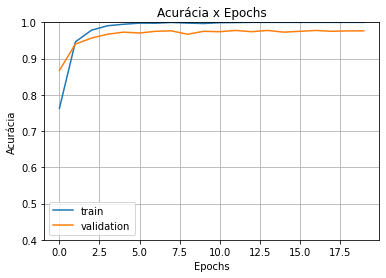

In [9]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1) 
plt.grid()
plt.title('Acurácia x Epochs')
plt.ylabel('Acurácia')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [10]:
classes = validation.class_names
classes

['BA', 'HA', 'MP', 'SE', 'SL', 'TP', 'TU', 'ZC']

##### Obtendo arrays de prova e predição para o conjunto de validação

In [11]:
y_true = []
y_pred = []
validation_images = []
# Itera entre as batchs geradas pela função que separou o dataset
for images, labels in validation:
    # Itera dentro das batchs para retirar os resultados esperados para cada imagem
    for label in labels:
        y_true.append(label)
    # Itera para recuperar as imagens correspondentes ao valor esperado
    # e salva a predição do modelo
    for image in images:
        validation_images.append(image)
        y_pred.append(model.predict(np.expand_dims(image, axis=0)))
y_true = np.array(y_true)
y_pred = np.array(y_pred)


In [12]:
# Manipulações nas dimensionalidades das saídas obtidas para adequação nos métodos
# que vão gerar as métricas
y_true_max = np.argmax(y_true, axis=1)
y_pred_max = np.argmax(y_pred, axis=2).flatten()


##### Inspecionando métricas do modelo para o conjunto de validação

In [30]:
report = classification_report(y_true_max, y_pred_max)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        77
           1       0.95      0.98      0.96       150
           2       0.99      0.99      0.99       181
           3       0.97      0.91      0.94       105
           4       0.97      0.97      0.97       130
           5       1.00      0.97      0.98        33
           6       0.98      1.00      0.99       118
           7       1.00      1.00      1.00        58

    accuracy                           0.98       852
   macro avg       0.98      0.98      0.98       852
weighted avg       0.98      0.98      0.98       852



##### Inspecionando imagens que o modelo errou em classificar

In [31]:
wrong_images = []
for index, test in enumerate(y_pred_max):
    if(y_pred_max[index] != y_true_max[index]):
        wrong_images.append(index)

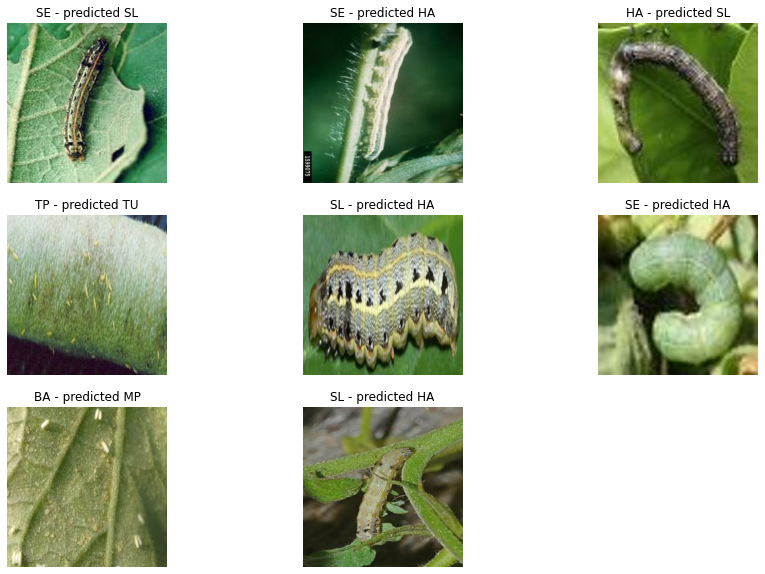

In [32]:
# Inspecionando imagens classificadas errado
fig = plt.figure(figsize=(15,10))
for i in range(8):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(validation_images[wrong_images[i]].numpy().astype("uint8"))
  plt.title(f'{class_names[y_true_max[wrong_images[i]]]} - predicted {class_names[y_pred_max[wrong_images[i]]]}')
  plt.axis("off")